# "기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기"
> "Pytorch Tutorial 따라서 코드 돌려보며, 내용 확인."

- toc:true
- branch: master
- badges: true
- comments: true
- author: In Chan
- categories: [jupyter, deep learning]

# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기
___

## 1. 데이터 준비

- Language.txt라는 텍스트 파일에 한 줄에는 이르밍 포함되어 있으며 대부분 로마자로 되어 있음.
- 각 언어 별로 이름 목록 딕셔너리 {language : [names ...]}을 만든다.


In [5]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path) 
print(findFiles('data/names/*.txt')) # path에 있는 txt 파일 모두 가져오기

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'" # a부터 Z + .,;'"까지.
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 각 파일 읽고 줄 단위로 분리해서, 카테고리 별로 딕셔너리 형태로 정리 
for filename in findFiles('data/names/*.txt'): 
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


## 2. 이름을 Tensor로 변경
- 하나의 문자를 표현하기 위해 크기가 **<1 x n_letters>**인 One-Hot 벡터를 사용
- 단어를 만들기 위해 원핫 벡터들을 2차원 핼렬 **<line_length x 1 x n_letters>** 에 결합시킴 
- 위에서 보이는 추가적인 1차원은 Batch로 생각하면 됨. (예제에서는 Batch 1을 사용함)

In [18]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어,글자 등을 벡터로 표현 할 때 단어,글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
동일하게 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용 할 수 있습니다.
'''

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) 
    for li, letter in enumerate(line): # li가 index, letter이 문자.
        tensor[li][0][letterToIndex(letter)] = 1 # 순서대로 하나씩 할당쓰
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 3. Network 생성
- 여러 시간 단계 걸처서 계층의 매개변수를 복제하는 작업을 포함. 
- 계층은 히든스테이트와 그레디언트를 가짐. 
- 교육목적으로 여기에서는 nn.RNN대신 직접 RNN을 구현

![image description>](https://i.imgur.com/Z2xbySO.png)


- 위의그래프와 동일한 내용을 코드로 torch.nn 모듈을 사용해 구현  

In [24]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

- 이 네트워크의 인풋으로 현재 문자와 이전의 히든 스테이트를 전달
- 출력으로는 다음 문자예측 확률(?)과 다음 히든 스테이트를 뱉음

In [28]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

- 효율을 위해 매 단계마다 새로운 Tensor를 만드는 letterToTensor 대신에 lineToTensor를 잘라서 사용
  - Outpus size 비교  
  - letterToTensor : output size = <1 x n_letters>  
  - lineToTensor를 : output size = <line_length x 1 x n_letters>

In [37]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9623, -2.8842, -2.8301, -3.0091, -2.8134, -2.8949, -2.9072, -2.9633,
         -2.9219, -2.8543, -2.9230, -2.8392, -2.8854, -2.8038, -2.9700, -2.8063,
         -2.9232, -2.8666]], grad_fn=<LogSoftmaxBackward>)


## 4. 학습

- 우리가 알아낸 각 카테고리의 확률인 네트워크의 출력을 해석하는 함수 
- 가장 큰 값의 주소를 알기 위해서 Tensor.topk를 사용할 수 있음. 
- 이는 네트워크의 출력이 가장 높은 카테고리 이름과 카테고리 번호를 반환 함.

In [46]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소 , 즉 top_n은 max값, top_i는 argmax 값
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 13)


- 하나의 이름과 그 언어를 얻는 빠른 방법도 필요

In [47]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)] # 0부터 len(l)-1까지의 숫자 중 무작위로 하나 Sample 

def randomTrainingExample():
    category = randomChoice(all_categories) # 카테고리에서 무작위로 하나 Sample 
    line = randomChoice(category_lines[category]) # 해당 category에서 무작위로 하나의 이름 Sample 
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # 해당 카테고리의 index를 반환
    line_tensor = lineToTensor(line) # 이름을 원핫 백터로 쪼개줌 
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Masson
category = Dutch / line = Bueren
category = Irish / line = Casey
category = French / line = Deniel
category = Vietnamese / line = Vo
category = English / line = Singh
category = Czech / line = Kouba
category = Scottish / line = Sinclair
category = Italian / line = Prosdocimi
category = Korean / line = Yeon


## 5. Network 학습

- RNN의 마지막 계층이 nn.LogsoftMax이므로 손실 함수로 nn.NLLLose가 적합
- 각 학습 루프는 다음과 같음
    - 입력과 목표 Tensor 생성
    - 0로 초기화된 은닉 상태 생성 **(각 Epoch마다 적용)**
    - 각 문자를 읽기
        - 다음 문자를 위한 은닉 상태 유지
    - 목표와 최종 출력 비교
    - 역전파
    - 출력과 손실 반환


In [53]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # 이것을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [54]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample() # 무작위로 1개의 단어 추출 
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.6400 Stueck / Spanish ✗ (German)
10000 10% (0m 20s) 2.7578 Said / Vietnamese ✗ (Arabic)
15000 15% (0m 30s) 1.8257 Truong / Chinese ✗ (Vietnamese)
20000 20% (0m 40s) 0.6166 Bertsimas / Greek ✓
25000 25% (0m 50s) 1.1281 Finnegan / Irish ✓
30000 30% (1m 0s) 0.9489 Chu / Vietnamese ✓
35000 35% (1m 10s) 0.7092 Qiu / Chinese ✓
40000 40% (1m 20s) 2.2543 Fritsch / Scottish ✗ (Czech)
45000 45% (1m 30s) 1.0722 Lorenz / German ✓
50000 50% (1m 40s) 0.2360 Shon / Korean ✓
55000 55% (1m 51s) 1.0983 Loyola / Spanish ✓
60000 60% (2m 2s) 2.1661 Han / Chinese ✗ (Korean)
65000 65% (2m 12s) 1.5942 Haggett / Scottish ✗ (English)
70000 70% (2m 22s) 0.4008 Entov / Russian ✓
75000 75% (2m 32s) 0.8115 Fei / Chinese ✓
80000 80% (2m 42s) 0.8383 Ferro / Portuguese ✓
85000 85% (2m 52s) 2.8902 Rojas / Greek ✗ (Spanish)
90000 90% (3m 3s) 0.4899 Zhuan / Chinese ✓
95000 95% (3m 13s) 1.6965 Stoep / Arabic ✗ (Dutch)
100000 100% (3m 23s) 1.5459 Poplawski / Russian ✗ (Polish)


## 6. 결과 도식화

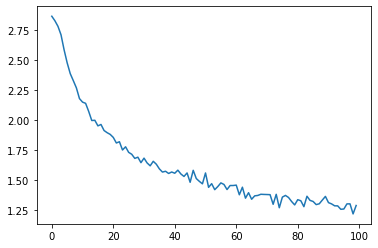

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 7. 결과 평가
- 네트워크가 다른 카테고리에서 예측을 잘 하는지를 확인하기 위해, Confusion Matrix 산출

ipykernel_launcher:33: UserWarning: FixedFormatter should only be used together with FixedLocator
ipykernel_launcher:34: UserWarning: FixedFormatter should only be used together with FixedLocator


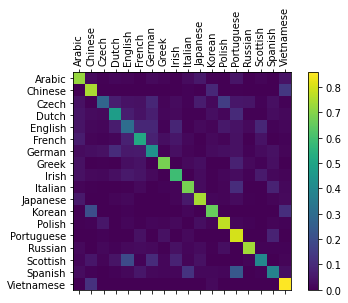

In [58]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [64]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Satoshi')
predict('Jackson')
predict('ChulSoo')


> Satoshi
(-1.10) Italian
(-1.38) Polish
(-1.85) Japanese

> Jackson
(-0.85) Scottish
(-1.12) English
(-1.77) Russian

> ChulSoo
(-0.95) Korean
(-1.66) Spanish
(-2.27) Scottish
